---
title: tweetデータを用いた自然言語分類モデルをつくってみる①
date: 2024-11-20
description: このノートでは、kaggleのtweetデータを用いた自然言語分類を行なっていきます
categories: [kaggle, nlp, fastai]
toc: true
---

# Getting started in NLP

このノートでは、`kaggle`のNLP(自然言語処理)を行う方法を紹介します。tweetデータから、そのtweetが災害についての発信であるかを分類します。深層学習には`fastai`ライブラリーを使用します。目標は`80% f1 score`でtweetを分類するモデルをつくることです。80%は`AutoML`のスコアを基にしたものです。

--

実装の流れは以下の通りです。

0. 必要なライブラリのインストール
1. 分類モデル用データセットを用意
2. 分類モデルの作成
3. kaggleに提出
4. まとめ
5. 参照リンク




## 0. 必要なライブラリのインストール

競技参加の同意・APIキーの取得を、テータセットのインストール前に行っていきましょう。

In [1]:
try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

from fastkaggle import *
from fastai.text.all import *

Note: you may need to restart the kernel to use updated packages.


In [2]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

## 1. 分類モデル用データセットを用意

tweetデータはcsvファイルで取得されます。各データセットのサンプル数は、トレーニングが7613、テストが3263です。一つの列に対して、1tweet・対応するラベル(1が災害、0が災害以外のtweet)が含まれています。

In [4]:
comp = "nlp-getting-started"

path = setup_comp(comp)
path.ls()

(#3) [Path('nlp-getting-started/sample_submission.csv'),Path('nlp-getting-started/test.csv'),Path('nlp-getting-started/train.csv')]

In [5]:
trn_df = pd.read_csv(path/"train.csv")
tst_df = pd.read_csv(path/"test.csv")
smp_df = pd.read_csv(path/"sample_submission.csv")

trn_df.shape, tst_df.shape, smp_df.shape

((7613, 5), (3263, 4), (3263, 2))

In [6]:
trn_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


トレーニングデータにはいくつかの重複データが含まれていますが、特にtextデータの重複には注意が必要です。学習・検証データを作成する際に、同一データが二つのデータセットにまたがって含まれないようにします。例えば、`11-Year-Old Boy Charged...`の文章が検証データに含まれている場合、学習データはそのtweetデータを含まないことになります。広く使用されているランダムな学習セットの用意は、このデータには不適切であることが分かります。

In [7]:
trn_df.describe(include="object")

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
freq,45,104,10


ここでは、以下の学習データセットに対して`target`の割合がどう変化するかを示します。面白い点は、keywordデータの欠如が災害tweetの割合を増やしている点です。一方locationデータの有無は、災害tweetの割合に影響を与えていません。これが何を示すのかは分かりませんが、keywordを含ませると何らかの情報(災害に関する)をモデルに渡すことが推測できます。

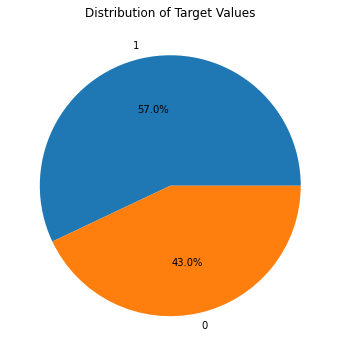

In [ ]:
def plot_target(df, title=""):
    plt.figure(figsize=(8, 6))
    plt.pie(df["target"].value_counts(), labels=df["target"].unique(), autopct='%1.1f%%')
    plt.title(title)
    plt.show()

plot_target(trn_df, "Distribution of Target Values")

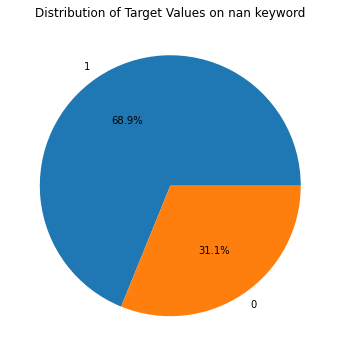

In [9]:
plot_target(trn_df[pd.isna(trn_df.keyword)], "Distribution of Target Values on nan keyword")

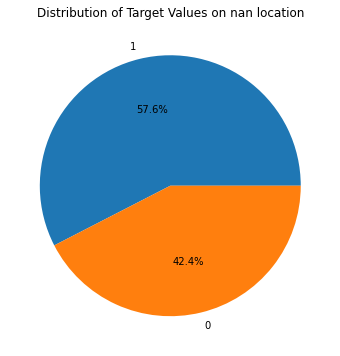

In [10]:
plot_target(trn_df[pd.isna(trn_df.location)], "Distribution of Target Values on nan location")

以下の関数`random_splitter`は、学習・検証セット間の同一データの重複(data leakage)を防ぎます。

In [ ]:
def random_splitter(df, val_pct=0.2):
    df = df.copy()
    df["uniq_text"] = df["text"].map(lambda x: hash(x))
    uniq_text = df["uniq_text"].unique()
    val_text_ids = set(random.sample(list(uniq_text), int(len(uniq_text) * val_pct)))

    trn_idx = df.index[~df["uniq_text"].isin(val_text_ids)].tolist()
    val_idx = df.index[df["uniq_text"].isin(val_text_ids)].tolist()
    return trn_idx, val_idx

# Check no duplicates across train/valid set
trn_idx, val_idx = random_splitter(trn_df)
print(len(trn_idx), len(val_idx))
set(trn_df.iloc[trn_idx]["text"]).intersection(set((trn_df.iloc[val_idx]["text"])))

6091 1522


set()

テストデータをざっくりと見ると、トレーニングデータと似通ったtweetデータが含まれていることが分かります。

In [12]:
tst_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
tst_df.describe(include="object")

,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
freq,23,38,3


次の`combine_cols`関数は、keyword・location・textデータを繫げます。各行の合間に挟まれる`xxfld`はテキストを繋げる際に使用される、fastaiのデフォルトのトークン([参照リンク](https://github.com/fastai/fastai/blob/master/fastai/text/core.py#L199))です。

In [14]:
# Ref: https://github.com/fastai/fastai/blob/master/fastai/text/core.py#L199
def combine_cols(df): return "xxfld 1 " + df["keyword"].fillna("") + " xxfld 2 " + df["location"].fillna("") + " xxfld 3 " + df["text"]
trn_df["text"] = combine_cols(trn_df)
tst_df["text"] = combine_cols(tst_df)

trn_df["text"].head(), tst_df["text"].head()

(0                                                                    xxfld 1  xxfld 2  xxfld 3 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
 1                                                                                                   xxfld 1  xxfld 2  xxfld 3 Forest fire near La Ronge Sask. Canada
 2    xxfld 1  xxfld 2  xxfld 3 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
 3                                                                        xxfld 1  xxfld 2  xxfld 3 13,000 people receive #wildfires evacuation orders in California 
 4                                                 xxfld 1  xxfld 2  xxfld 3 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
 Name: text, dtype: object,
 0                                                                  xxfld 1  xxfld 2  xxfld 3 Just happened a terrible car crash
 1           

分類学習モデル用のデータを用意し表示します。

In [15]:
def get_dls(df, seq_len=72, vocab=None, backwards=False, splitter=random_splitter, bs=256):
    return DataBlock(
        blocks=(TextBlock.from_df("text", seq_len=seq_len, vocab=vocab, backwards=backwards), CategoryBlock),
        get_x=ColReader("text"),
        get_y=ColReader("target"),
        splitter=splitter
    ).dataloaders(df, bs=bs)

dls = get_dls(trn_df)
dls.show_batch(max_n=5)

,text,category
0,xxbos xxfld 1 army xxfld 2 xxmaj pakistan xxfld 3 . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
1,"xxbos xxfld 1 curfew xxfld 2 xxmaj adelaide , xxmaj australia xxfld 3 xxup info xxup r. xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup wnd : xxunk / 5 . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup xxunk . xxup tmp : 10 . xxup xxunk : xxunk .",0
2,"xxbos xxfld 1 curfew xxfld 2 xxmaj adelaide , xxmaj australia xxfld 3 xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .",0
3,xxbos xxfld 1 death xxfld 2 xxup xxunk ? ? xxfld 3 i xxmaj hate xxmaj to xxmaj talking xxmaj xxunk xxmaj with xxmaj my xxmaj xxunk … i xxmaj mean i xxmaj love xxmaj her xxmaj as xxmaj to xxmaj death xxmaj but xxmaj she xxmaj talk xxmaj so xxmaj damn xxmaj much xxmaj xxunk xxrep 3 h xxrep 3 e xxunk xxrep 3 ! xxrep 6 ?,0
4,xxbos xxfld 1 hostages xxfld 2 xxfld 3 xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1


## 2. 分類モデルの作成

データセットの用意ができたら、分類モデルの作成を行います。モデルには`AWD_LSTM`
を使用します。少ないトレーニングデータ(約7000サンプル数)のため、モデルは直ぐに過学習に達します。

では、過学習はどのように対処していくのか？ということを考えてみます。よくある間違いはモデルの複雑性を減らし、パラメーター数の少ないモデルに変えることです。これは最後に行うステップです。まずは、**過学習にはより多くのデータを使用することを第一** に考えます。単純な例として、ここではテキストを逆方法に、最後の文字→最初の文字へと学習させてみましょう(厳密に言うとデータ拡張になりますが、あまり気にしないでください)。

SuggestedLRs(valley=0.001737800776027143)

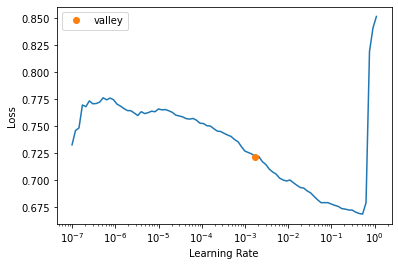

In [16]:
def get_classifier(dls, backwards=False): return text_classifier_learner(dls, AWD_LSTM, backwards=backwards, drop_mult=0.5, metrics=[Perplexity, F1Score()]).to_fp16()
learn = get_classifier(dls)
learn.lr_find()

In [17]:
learn.fine_tune(6, 5e-3, wd=0.03)

epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.658422,0.599893,1.821924,0.639466,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.588272,0.534196,1.706076,0.669864,00:08
1,0.563553,0.489243,1.631081,0.687669,00:09
2,0.535022,0.486653,1.626862,0.716150,00:09
3,0.507074,0.464368,1.591009,0.725888,00:08
4,0.482312,0.454961,1.576113,0.728656,00:09
5,0.461974,0.456902,1.579175,0.738664,00:08


In [18]:
learn.show_results(max_n=4)

,text,category,category_
0,xxbos xxfld 1 mayhem xxfld 2 ? ? xxmaj made in the xxmaj philippines ? ? xxfld 3 _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0,0
1,"xxbos xxfld 1 curfew xxfld 2 xxmaj adelaide , xxmaj australia xxfld 3 xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .",0,0
2,xxbos xxfld 1 weapon xxfld 2 xxmaj washington xxup dc xxfld 3 xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup au # xxup xxunk,1,1
3,xxbos xxfld 1 casualties xxfld 2 xxmaj the low - xxunk xxmaj xxunk xxmaj zone xxfld 3 xxup i 'm xxup laughing xxup in xxup the xxup face xxup of xxup casualties xxup and xxup xxunk xxup the xxup first xxup time xxup i 'm xxup thinking xxup past xxup tomorrow xxup but i xxup am xxup not xxup xxunk xxup away xxup my xxup shot,1,0


逆さ文章を表示した後、モデルを学習します。先の(順方向)モデルと比較しても、今回の(逆方向)モデルも妥当なスコアを出すことが分かります。ここでの注意ポイントは、データと合わせて**モデルにも`backwards=True`を渡す**ことです。逆方向に合わせた学習済み重みが、`backwards`を設定することで、転移学習に使用されます。詳細は[こちらのコード](https://github.com/fastai/fastai/blob/master/fastai/text/learner.py#L254)の確認を。

In [20]:
get_dls(trn_df, backwards=True).show_batch(max_n=2)

,text,category
0,ty xxup # \n▁ xxunk xxup # xxunk ? follow xxup ? 5 xxrep \n▁ ? 7 xxrep \n▁ with xxup gain xxup ? 5 xxrep \n▁ ? 7 xxrep \n▁ xxunk xxup ? 5 xxrep \n▁ ? 7 xxrep \n▁ rt xxup who xxup all xxup follow xxup ? 5 xxrep \n▁ ? 7 xxrep \n▁ retweet xxup ? 5 xxrep \n▁ _ 3 xxfld ? ? philippines xxmaj the in made xxmaj ? ? 2 xxfld mayhem 1 xxfld xxbos,0
1,". 6 / xxunk : wnd xxup . 10 : tmp xxup . navbl xxup 6 foxtrot xxup & & 5 foxtrot xxup taxiways xxup z. xxup 2030 until xxup oper xxup in xxup curfew xxup . 05 rwy xxup . apch xxup inst xxup exp xxup . xxunk xxup xxunk xxup : xxunk xxup u. xxup info xxup 3 xxfld australia xxmaj , adelaide xxmaj 2 xxfld curfew 1 xxfld xxbos",0


In [21]:
learn = get_classifier(get_dls(trn_df, backwards=True), backwards=True)
learn.fine_tune(6, 5e-3, wd=0.03)

epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.612321,0.539246,1.714714,0.700943,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.543969,0.488203,1.629385,0.699911,00:08
1,0.522194,0.463604,1.589794,0.740679,00:08
2,0.499041,0.445374,1.561074,0.750000,00:08
3,0.477004,0.440480,1.553453,0.751048,00:08
4,0.455625,0.441258,1.554661,0.763072,00:09
5,0.436592,0.443257,1.557772,0.763309,00:09


## 3. kaggleに提出

では、kaggleに提出用のファイルを作成します。4つのモデル(2順方向・2逆方向)を組み合わせて、最終スコアの精度を上げます。

In [23]:
preds = []
for i in range(4):
    backwards = (i%2==1)
    learn = get_classifier(get_dls(trn_df, backwards=backwards), backwards=backwards)
    learn.fine_tune(8, 5e-3, wd=0.03)
    pred = learn.get_preds(dl=learn.dls.test_dl(tst_df))[0]
    preds.append(pred)

epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.677151,0.617163,1.853663,0.687425,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.590248,0.495130,1.640712,0.711262,00:08
1,0.571887,0.506855,1.660062,0.724490,00:09
2,0.544579,0.436301,1.546974,0.751494,00:09
3,0.515391,0.433388,1.542475,0.780450,00:09
4,0.491986,0.433089,1.542014,0.789033,00:09
5,0.470065,0.429307,1.536193,0.789147,00:08
6,0.448351,0.434152,1.543654,0.787510,00:09
7,0.431437,0.424780,1.529254,0.790008,00:09


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.617464,0.540031,1.716060,0.726718,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.537951,0.481259,1.618110,0.735294,00:09
1,0.524030,0.496447,1.642873,0.757093,00:08
2,0.505570,0.458025,1.580948,0.772795,00:08
3,0.482626,0.456221,1.578099,0.768526,00:09
4,0.459708,0.446411,1.562694,0.766458,00:09
5,0.437200,0.456399,1.578380,0.783704,00:09
6,0.414401,0.454099,1.574754,0.779789,00:09
7,0.401246,0.452466,1.572185,0.781155,00:08


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.657558,0.589393,1.802894,0.703857,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.603144,0.505390,1.657633,0.718028,00:09
1,0.579316,0.457990,1.580893,0.722569,00:09
2,0.551933,0.453589,1.573950,0.752672,00:09
3,0.523351,0.459823,1.583794,0.761835,00:09
4,0.494781,0.451828,1.571181,0.774340,00:09
5,0.470976,0.442031,1.555864,0.778774,00:09
6,0.449637,0.433513,1.542667,0.777948,00:09
7,0.433776,0.442702,1.556909,0.777022,00:09


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.614581,0.544251,1.723318,0.724109,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.539059,0.456626,1.578739,0.762353,00:09
1,0.518621,0.436470,1.547236,0.775324,00:09
2,0.500680,0.427625,1.533611,0.783975,00:08
3,0.480591,0.423821,1.527788,0.796325,00:09
4,0.458144,0.416781,1.517070,0.779984,00:09
5,0.437416,0.421846,1.524774,0.796636,00:09
6,0.418690,0.423488,1.527280,0.793529,00:08
7,0.405416,0.421054,1.523567,0.795966,00:08


In [25]:
smp_df["target"] = torch.max(sum(preds), dim=-1).indices
smp_df.to_csv(path/"submission.csv", index=False)
!head {path}/submission.csv

id,target
0,1
2,1
3,1
9,1
11,1
12,1
21,0
22,0
27,0


In [26]:
from kaggle import api
api.competition_submit_cli(path/"submission.csv", "finetuned model", comp)

100%|██████████| 22.2k/22.2k [00:00<00:00, 71.2kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets

最後に先にインストールしたデータを削除します。

In [28]:
!rm -rf {path}
!rm nlp-getting-started.zip

## 4 まとめ

![kaggle の結果](result.png "kaggleの結果")

目標値`80% f1 score`を達成することができました。次のブログでは、Jeremy Howardさんの論文から、[ulmfit](https://arxiv.org/abs/1801.06146)で使用された転移学習のやり方を見ていきます。

もしも読者がこのノートを役に立ったと思ったら、リアクションボタンを押してもらえると幸いです。質問や間違いがあれば、以下コメント欄に書き込んでください。

## 5.参照リンク

* [kaggle公式競技ページ](https://www.kaggle.com/competitions/nlp-getting-started/overview)
* [fastai NLP チュートリアル](https://docs.fast.ai/tutorial.text.html)
* [text_classifier_learner関数のドキュメント](https://docs.fast.ai/text.learner.html#learner-convenience-functions)